In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#matplotlib options
plt.rc('font', family='serif', size=12)
pltops_hist = { "histtype":'step', "linewidth":1.5}
plt.rc('image', cmap='seismic')
plt.rcParams['figure.figsize'] = [10.0, 8.0]

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k','indigo','orange','#137e6d'])

def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg(['mean',option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={'mean': 'y', option: 'yerr'}, inplace=True)
    return result

def make_hists(df,hists,bins,axis,histtype='step',stacked=True):
    n,cbins,patches = axis.hist([df.query(hd['cut'])[hd['var']] for hd in hists],
                                weights=[df.query(hd['cut'])[hd['weight']] for hd in hists],
                                label=["%s: %.1f"%(hd['label'],df.query(hd['cut'])[hd['weight']].sum()) for hd in hists],
                                bins=bins,histtype=histtype,stacked=stacked)
    for i in range(0,len(patches)):
        hd = hists[i]
        for p in patches[i]:
            if 'color' in hd: p.set_color(hd['color'])
            if 'facecolor' in hd: p.set_facecolor(hd['facecolor'])
            if 'edgecolor' in hd: p.set_edgecolor(hd['edgecolor'])
            if 'fill' in hd: p.set_fill(hd['fill'])
            if 'hatch' in hd: p.set_hatch(hd['hatch'])
            if 'linewidth' in hd: p.set_linewidth(hd['linewidth'])

In [3]:
%matplotlib notebook

In [4]:
ev_df_cv = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/CVSet/mcana_dfs.h5","ev_df")
pot_df_cv = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/CVSet/mcana_dfs.h5","pot_df")
cv_title = "$\mu$BooNE CV"
cv_leg = "CV"

In [5]:
ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/mcana_dfs.h5","ev_df")
pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/mcana_dfs.h5","pot_df")
fd_title = "Fake Data Set 2"
fd_leg="Set2"

In [6]:
#split for run1 and run3
ev_df_cv = ev_df_cv.reset_index()
ev_df_fd = ev_df_fd.reset_index()
ev_df_cv = ev_df_cv.astype({"run":"int64","subrun":"int64","event":"int64"})
ev_df_fd = ev_df_fd.astype({"run":"int64","subrun":"int64","event":"int64"})

query_run1_cv = "run<35559325"
query_run3_cv = "run>35559325"
query_run1_fd = "run<32044000"
query_run3_fd = "run>32044000"

ev_df_cv_run1 = ev_df_cv.query(query_run1_cv)
ev_df_cv_run3 = ev_df_cv.query(query_run3_cv)
ev_df_fd_run1 = ev_df_fd.query(query_run1_fd)
ev_df_fd_run3 = ev_df_fd.query(query_run3_fd)

pot_df_fd = pot_df_fd.reset_index()
pot_df_fd = pot_df_fd.astype({"run":"int64","subrun":"int64"})

In [7]:
# POT not in CV. Use POT/event number from GENIE v2 for now ...
#total_pot_cv = pot_df_cv["totpot"].sum()
#total_pot_cv = len(ev_df_cv)*(1.222e19/4448.)
#print(len(ev_df_cv))
total_pot_cv=9.41e20

total_pot_cv_run1 = total_pot_cv * float(len(ev_df_cv_run1))/float(len(ev_df_cv))
total_pot_cv_run3 = total_pot_cv * float(len(ev_df_cv_run3))/float(len(ev_df_cv))


total_pot_fd = pot_df_fd["totpot"].sum()
total_pot_fd_run1 = pot_df_fd.query(query_run1_fd)["totpot"].sum()
total_pot_fd_run3 = pot_df_fd.query(query_run3_fd)["totpot"].sum()

weight_pot_fd = total_pot_fd/total_pot_cv
weight_pot_fd_run1 = total_pot_fd_run1/total_pot_cv_run1
weight_pot_fd_run3 = total_pot_fd_run3/total_pot_cv_run3
#weight_pot_fd = 0.8

print("POT, CV=%.2E\nPOT, Fake Data=%.2E\nPOT Weight=%f"%(total_pot_cv,total_pot_fd,weight_pot_fd))
print("\tRun1: POT CV=%.2E, POT Fake Data=%.2E, POT Weight=%f"%(total_pot_cv_run1,total_pot_fd_run1,weight_pot_fd_run1))
print("\tRun3: POT CV=%.2E, POT Fake Data=%.2E, POT Weight=%f"%(total_pot_cv_run3,total_pot_fd_run3,weight_pot_fd_run3))

ev_df_cv.loc[:,("weight_pot")] = np.full(len(ev_df_cv),weight_pot_fd)
ev_df_cv_run1.loc[:,("weight_pot")] = np.full(len(ev_df_cv_run1),weight_pot_fd_run1)
ev_df_cv_run3.loc[:,("weight_pot")] = np.full(len(ev_df_cv_run3),weight_pot_fd_run3)

POT, CV=9.41E+20
POT, Fake Data=8.19E+20
POT Weight=0.870460
	Run1: POT CV=4.36E+20, POT Fake Data=4.08E+20, POT Weight=0.934670
	Run3: POT CV=5.05E+20, POT Fake Data=4.11E+20, POT Weight=0.814953


/Library/Python/3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
#apply fiducial volume

MIN_X = 0.
MAX_X = 254.
MIN_Y = -115.
MAX_Y = 115.
MIN_Z = 0.
MAX_Z = 1036.
fid_vol_query = "start_x>%f and start_x<%f and start_y>%f and start_y<%f and start_z>%f and start_z<%f"%(MIN_X,MAX_X,MIN_Y,MAX_Y,MIN_Z,MAX_Z)

ev_df_cv = ev_df_cv.query(fid_vol_query)
ev_df_fd = ev_df_fd.query(fid_vol_query)
ev_df_cv_run1 = ev_df_cv_run1.query(fid_vol_query)
ev_df_fd_run1 = ev_df_fd_run1.query(fid_vol_query)
ev_df_cv_run3 = ev_df_cv_run3.query(fid_vol_query)
ev_df_fd_run3 = ev_df_fd_run3.query(fid_vol_query)

In [9]:
total_evs_cv = ev_df_cv["weight_pot"].sum()
total_evs_fd = len(ev_df_fd)
weight_ev = total_evs_fd/float(total_evs_cv)

print("Events, CV=%d\nEvent, Fake Data=%d\nRatio (Fake/CV)=%f"%(total_evs_cv,total_evs_fd,weight_ev))
print("\tEvents CV=%d, Events Fake Data=%d, Ratio (Fake/CV)=%f"%(ev_df_cv_run1["weight_pot"].sum(),
                                                                 len(ev_df_fd_run1),
                                                                 len(ev_df_fd_run1)/ev_df_cv_run1["weight_pot"].sum()))
print("\tEvents CV=%d, Events Fake Data=%d, Ratio (Fake/CV)=%f"%(ev_df_cv_run3["weight_pot"].sum(),
                                                                 len(ev_df_fd_run3),
                                                                 len(ev_df_fd_run3)/ev_df_cv_run3["weight_pot"].sum()))

Events, CV=298090
Event, Fake Data=363353
Ratio (Fake/CV)=1.218934
	Events CV=148198, Events Fake Data=179683, Ratio (Fake/CV)=1.212449
	Events CV=149865, Events Fake Data=183670, Ratio (Fake/CV)=1.225563


In [10]:
query_1mu0p = "n_mu==1 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1mu1p = "n_mu==1 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1muNp = "n_mu==1 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1muXp = "n_mu==1 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"

query_1e0p = "n_mu==0 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1e1p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1eNp = "n_mu==0 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1eXp = "n_mu==0 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"

query_ccpi0 = "n_mu==1 and n_pi0>0 and n_e==0"
query_ncpi0 = "n_mu==0 and n_pi0>0 and n_e==0"

query_1g0p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1g1p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1gNp = "n_mu==0 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1gXp = "n_mu==0 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"

In [11]:
query_numu_cc = "pdgcode==14 and n_mu==1"
query_numu_nc = "pdgcode==14 and n_mu==0"
query_nue_cc = "pdgcode==12 and n_e==1"
query_nue_nc = "pdgcode==12 and n_e==0"

query_numu_ccqe = "pdgcode==14 and n_mu==1 and mode==0"
query_numu_ncqe = "pdgcode==14 and n_mu==0 and mode==0"
query_numu_ccmec = "pdgcode==14 and n_mu==1 and mode==10"
query_numu_ncmec = "pdgcode==14 and n_mu==0 and mode==10"
query_numu_ccres = "pdgcode==14 and n_mu==1 and mode!=0 and mode!=10" 
query_numu_ncres = "pdgcode==14 and n_mu==0 and mode!=0 and mode!=10"

query_nue_ccqe = "pdgcode==12 and n_e==1 and mode==0"
query_nue_ncqe = "pdgcode==12 and n_e==0 and mode==0"
query_nue_ccmec = "pdgcode==12 and n_e==1 and mode==10"
query_nue_ncmec = "pdgcode==12 and n_e==0 and mode==10"
query_nue_ccres = "pdgcode==12 and n_e==1 and mode!=0 and mode!=10" 
query_nue_ncres = "pdgcode==12 and n_e==0 and mode!=0 and mode!=10"

<IPython.core.display.Javascript object>


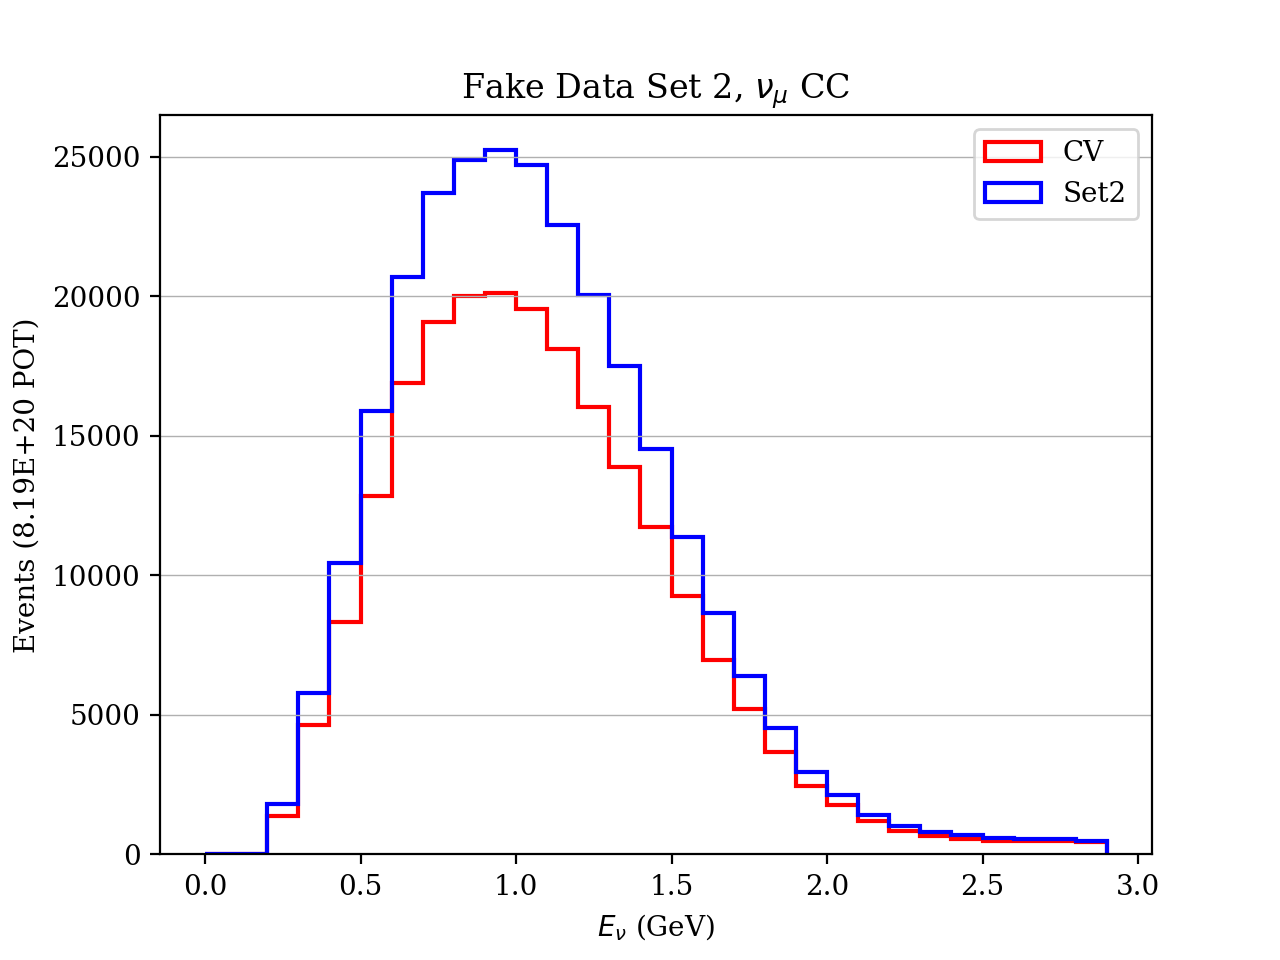

In [12]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_set1.png")

<IPython.core.display.Javascript object>


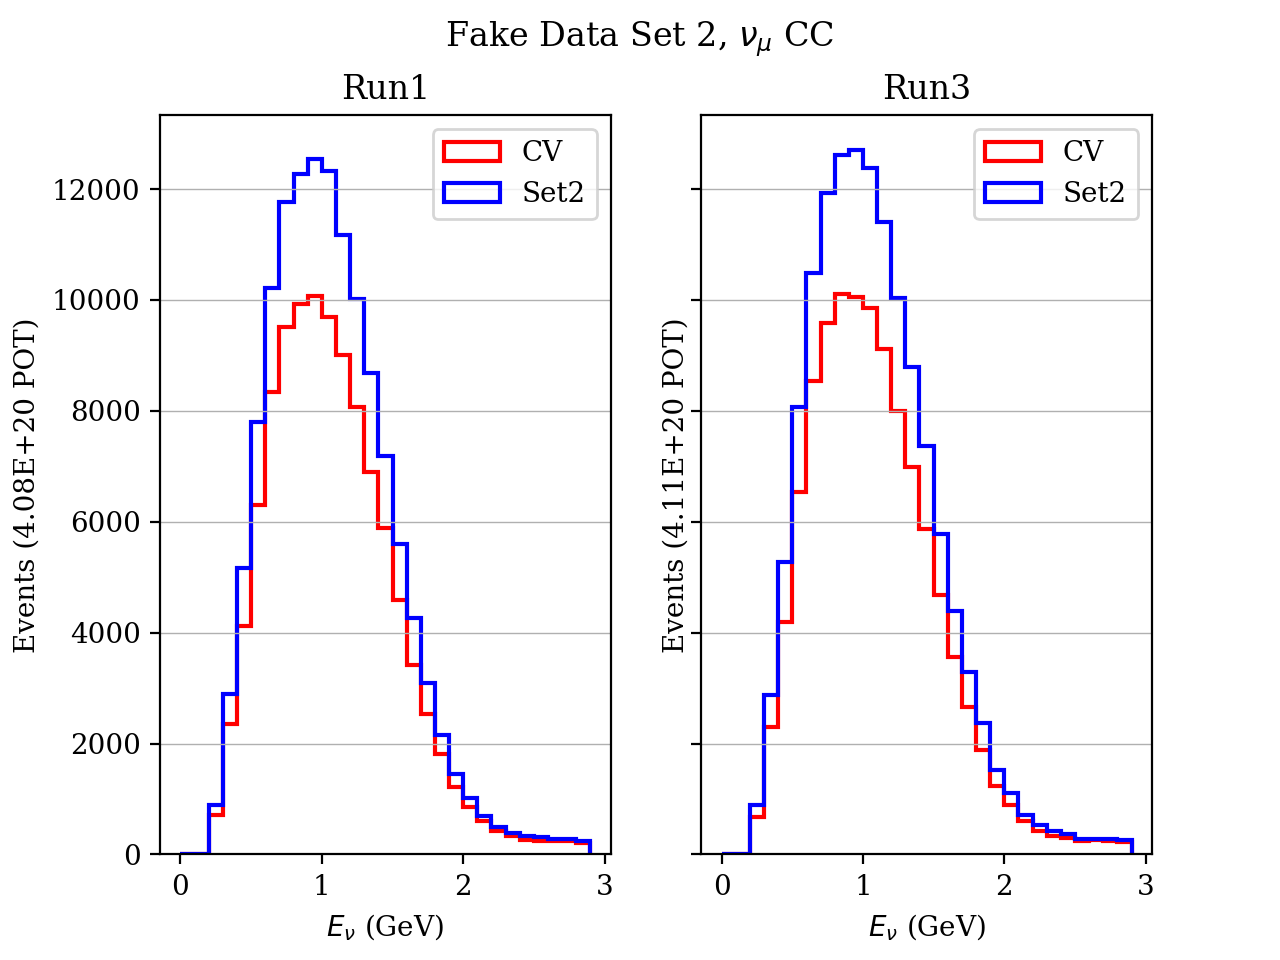

In [13]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel=["Events (%.2E POT)"%(total_pot_fd_run1),"Events (%.2E POT)"%(total_pot_fd_run3)]

df_cv = [ev_df_cv_run1.query(q),ev_df_cv_run3.query(q)]
df_fd = [ev_df_fd_run1.query(q),ev_df_fd_run3.query(q)]

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

for i in range(len(ax)):
    ax[i].grid(axis='y', linewidth=0.5)
    ax[i].hist(df_cv[i][var], weights=df_cv[i]["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
    ax[i].hist(df_fd[i][var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
    ax[i].legend()
    ax[i].set_title(subtitle[i])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel[i])
plt.suptitle(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_set1_runs.png")

<IPython.core.display.Javascript object>


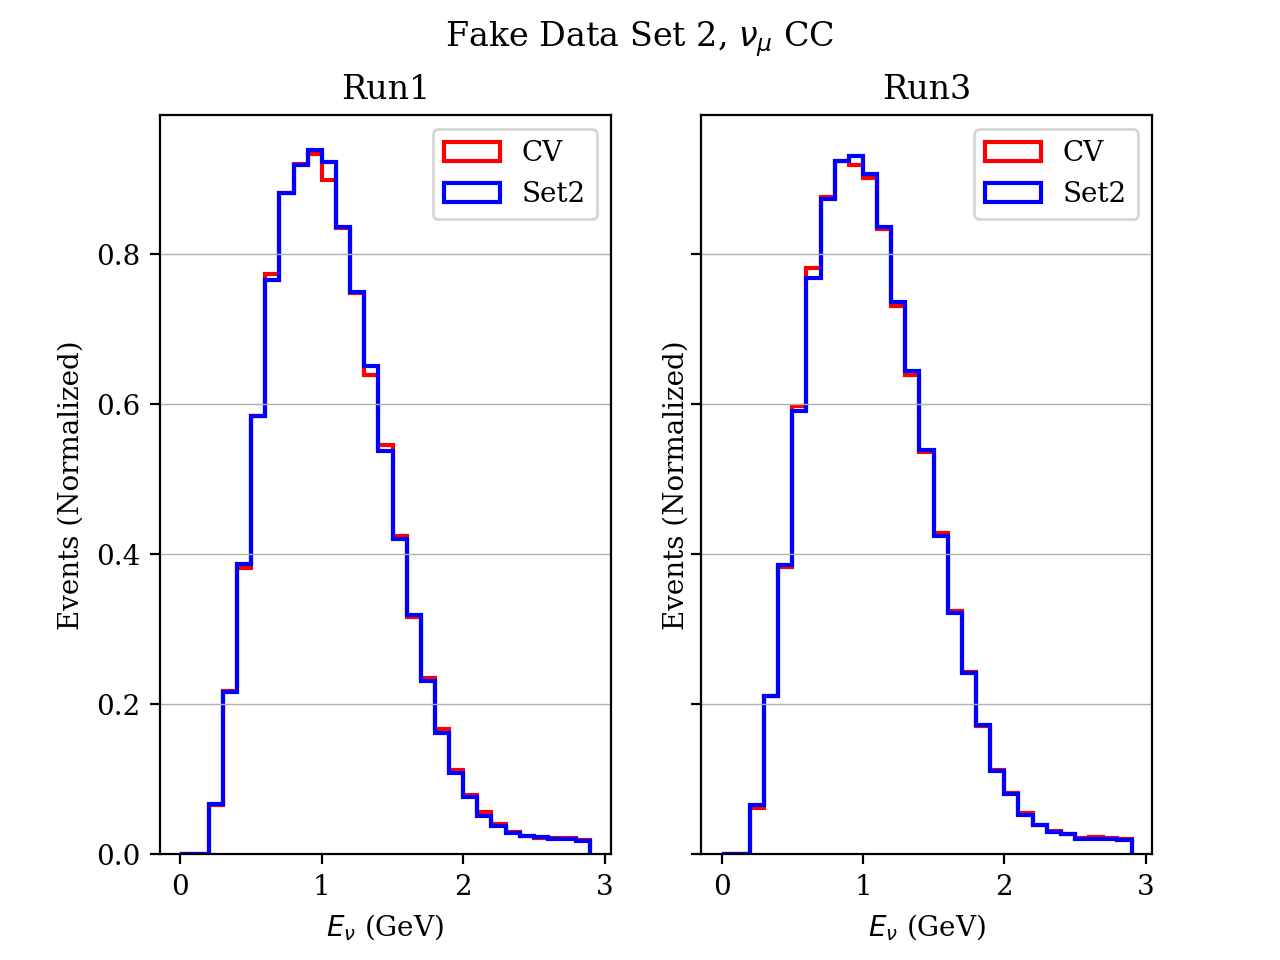

In [14]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
subtitle = ["Run1","Run3"]
xlabel="$E_{\\nu}$ (GeV)"
ylabel=["Events (Normalized)","Events (Normalized)"]

df_cv = [ev_df_cv_run1.query(q),ev_df_cv_run3.query(q)]
df_fd = [ev_df_fd_run1.query(q),ev_df_fd_run3.query(q)]

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

for i in range(len(ax)):
    ax[i].grid(axis='y', linewidth=0.5)
    ax[i].hist(df_cv[i][var], weights=df_cv[i]["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist,density=True)
    ax[i].hist(df_fd[i][var], color='blue', label=fd_leg, bins=bins,**pltops_hist,density=True)
    ax[i].legend()
    ax[i].set_title(subtitle[i])
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel[i])
plt.suptitle(title)
#plt.xlabel(xlabel)
#plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/numucc_e_set1_runs_norm.png")

<IPython.core.display.Javascript object>


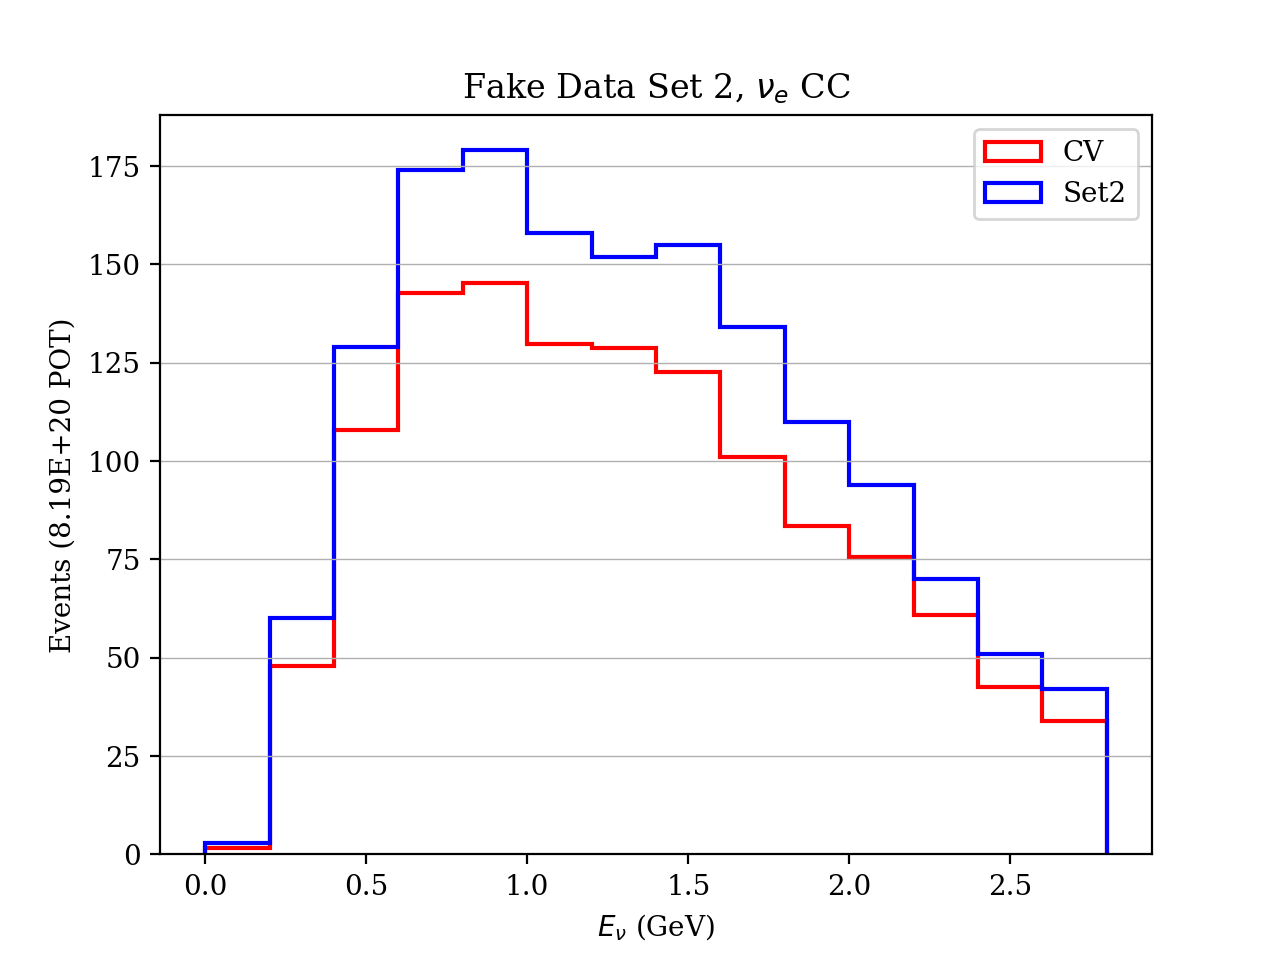

In [15]:
bins = np.arange(0,3.0,0.2)
var="e"
q=query_nue_cc
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


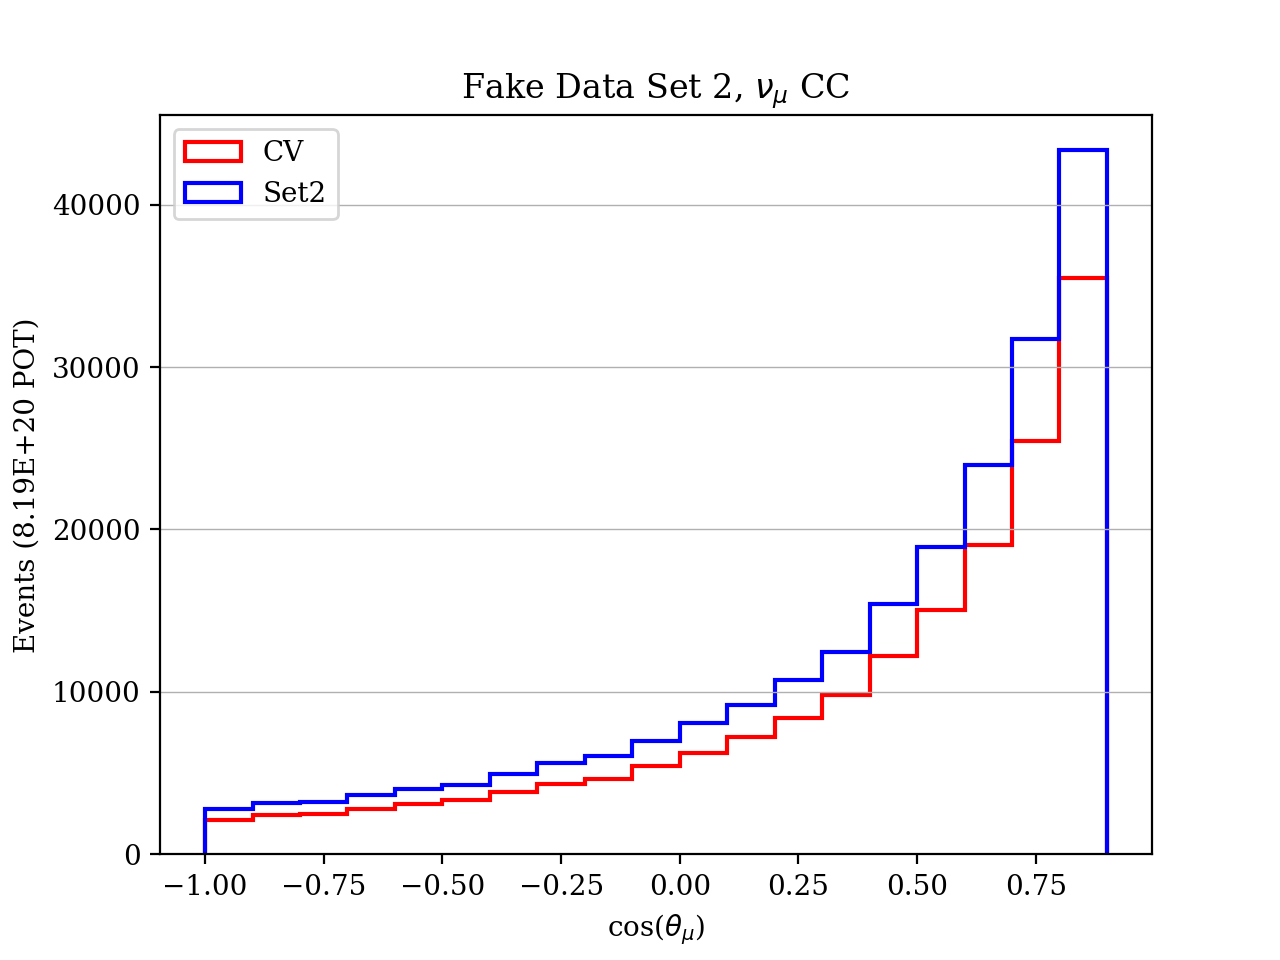

In [16]:
bins = np.arange(-1.0,1.0,0.1)
var="costheta_lep"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="cos($\\theta_{\mu}$)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


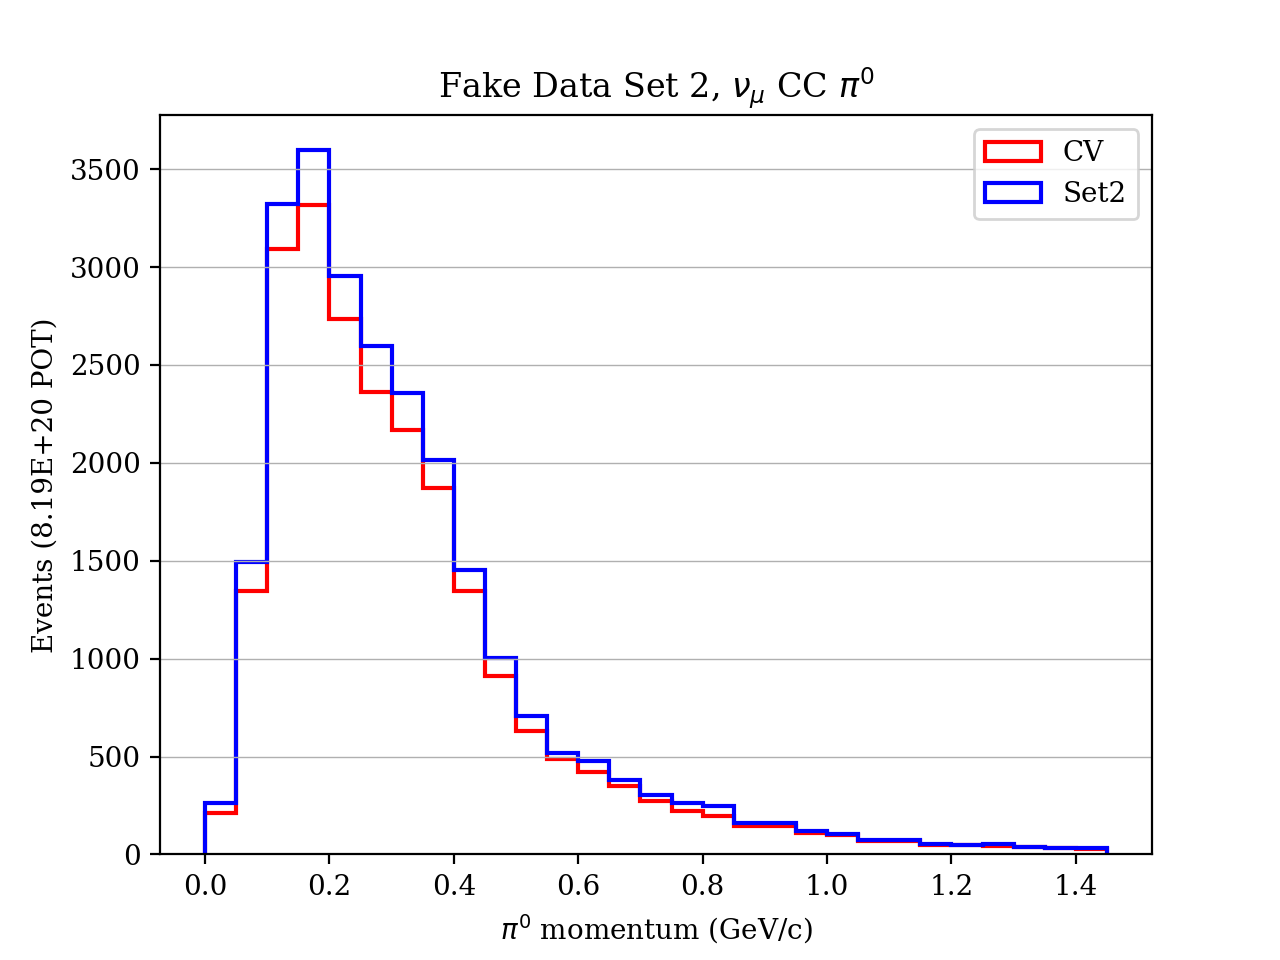

In [17]:
bins = np.arange(0.0,1.5,0.05)
var="p_pi0"
q=query_ccpi0
title="%s, $\\nu_\mu$ CC $\pi^0$"%(fd_title)
xlabel="$\pi^0$ momentum (GeV/c)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ccpi0_set1.png")

<IPython.core.display.Javascript object>


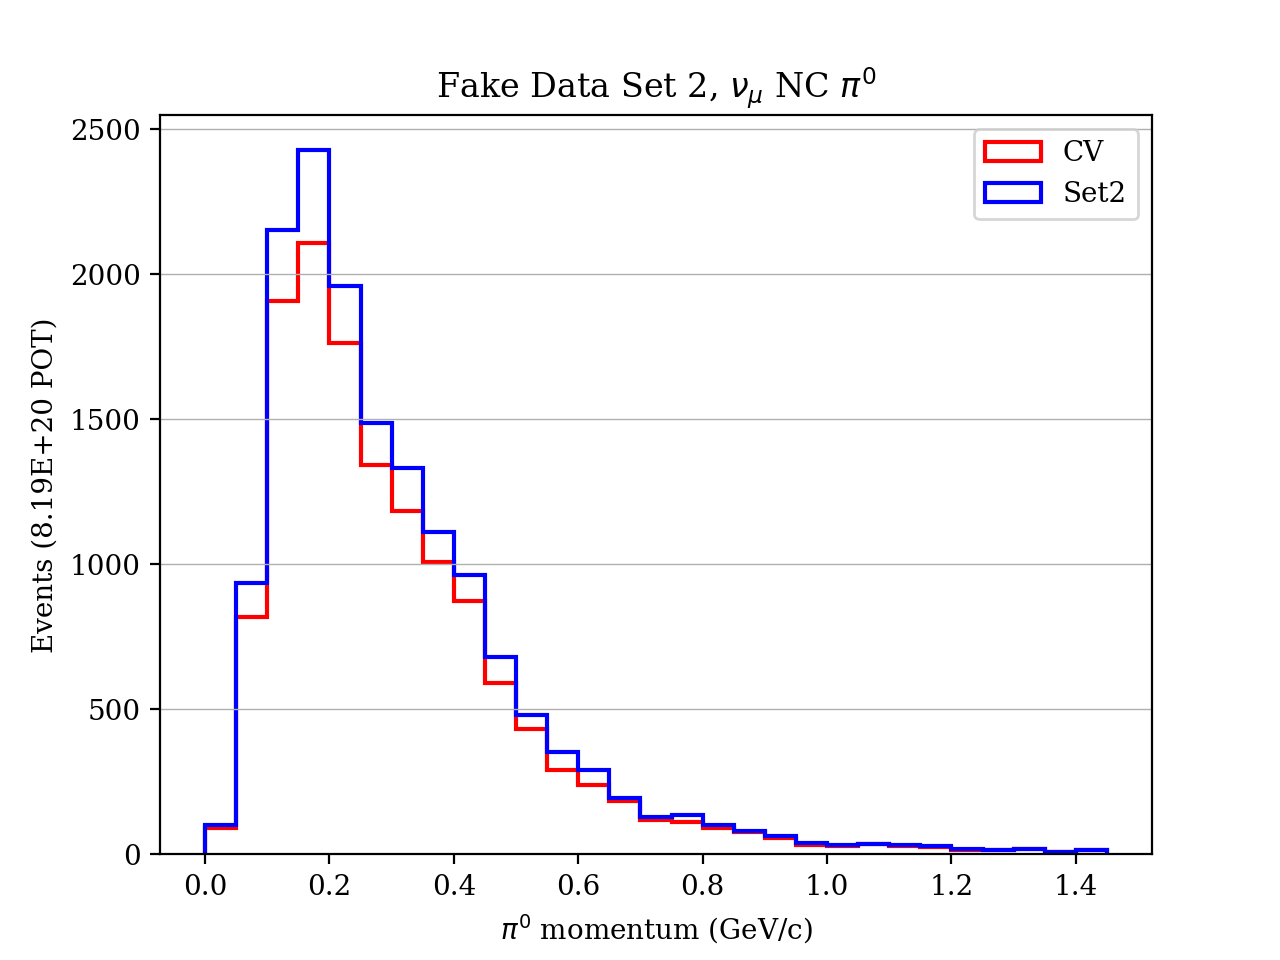

In [18]:
bins = np.arange(0.0,1.5,0.05)
var="p_pi0"
q=query_ncpi0
title="%s, $\\nu_\mu$ NC $\pi^0$"%(fd_title)
xlabel="$\pi^0$ momentum (GeV/c)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


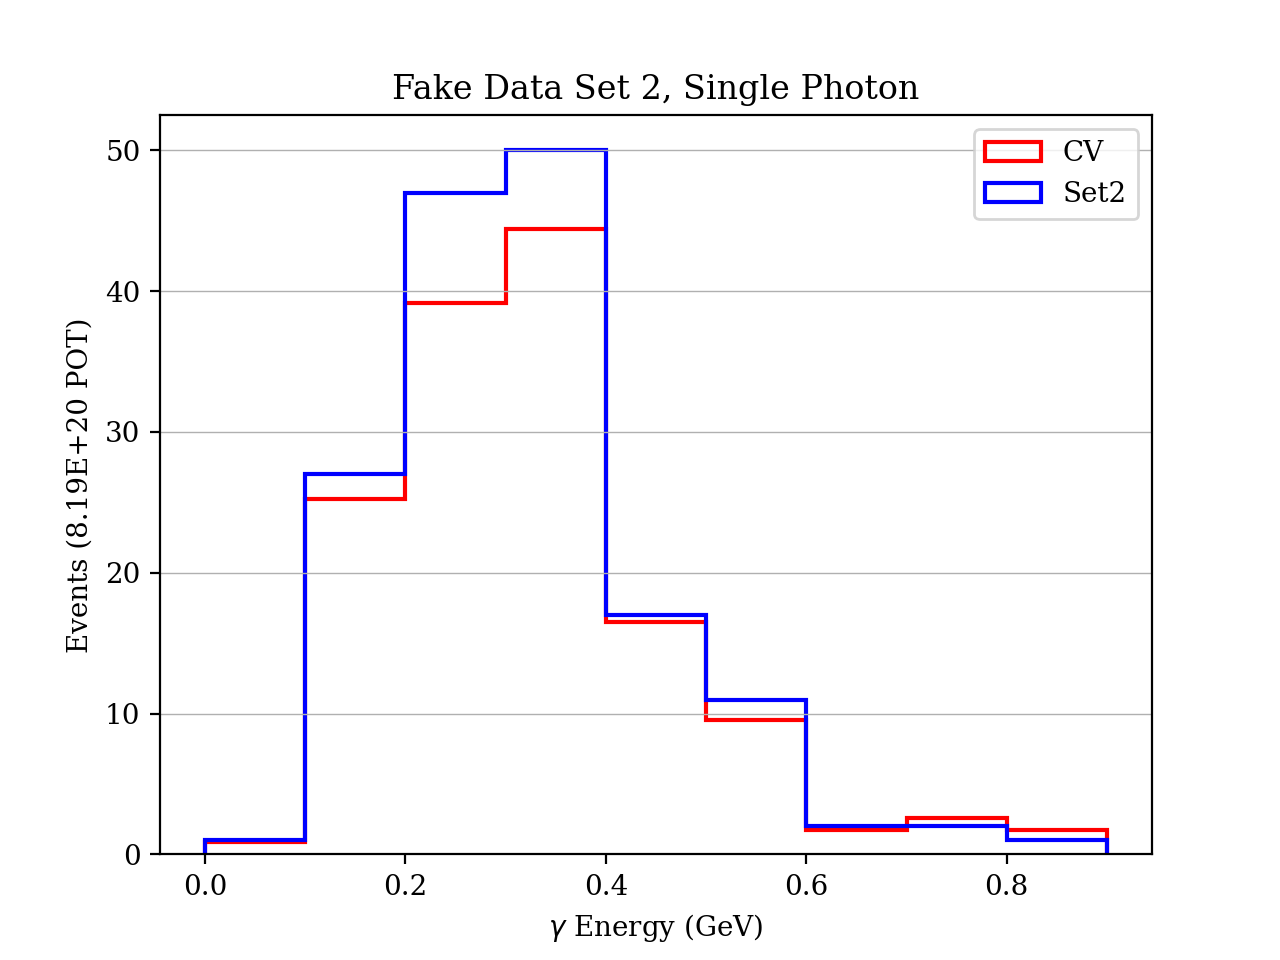

In [19]:
bins = np.arange(0.0,1.,0.1)
var="e_gamma"
q=query_1gXp
title="%s, Single Photon"%(fd_title)
xlabel="$\gamma$ Energy (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")